Let's look how can we combbine old competition data with the current one. For that we can do two things first:
- Run binary classification old vs new data. In ideal case samples coming from the new and old data shouldn't be separated.
- Since we have label (0\1) for each of sample of the old data, we can take models, trained only on new data and see how coherent the predictions are on the old data

In [1]:
import sys
sys.path.append('../')
import warnings
from torch.utils.data import DataLoader, Dataset
from src.pl_module import MelanomaModel
import pandas as pd
import torch
import torch.nn as nn
from typing import Tuple
import albumentations as A
from tqdm.auto import tqdm
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

Load trained models and make dataset

In [2]:
def load_model(model_name: str, model_type: str, weights: str):
    model = MelanomaModel.net_mapping(model_name, model_type)
    model.load_state_dict(
        torch.load(weights)
    )
    model.eval()
    model.cuda()
    print("Loaded model {} from checkpoint {}".format(model_name, weights))
    return model

class MelanomaDataset(Dataset):
    def __init__(self, image_folder, df, transform=None):
        super().__init__()
        self.image_folder = image_folder
        self.df = df
        self.transform = transform

    def __len__(self) -> int:
        return self.df.shape[0]

    def __getitem__(self, index) -> Tuple[torch.Tensor, torch.Tensor]:
        row = self.df.iloc[index]
        img_id = row.image_name
        img_path = f"{self.image_folder}/{img_id}.jpg"
        image = skimage.io.imread(img_path)
        if self.transform is not None:
            image = self.transform(image=image)['image']
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image)
        target = row.target
        return{'features': image, 'img_id': img_id, 'target': target}


def get_valid_transforms():
    return A.Compose(
        [
            A.Normalize()
        ],
        p=1.0)

In [3]:
old_data = pd.read_csv('../data/external_train.csv')
old_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [4]:
model_name_list = ['resnest26d'] * 5
model_type_list = ['SingleHeadMax'] * 5
weights_list = [f'../weights/resnest26d_128x128_fold{x}.pth' for x in range(5)]
models = [load_model(model_name, model_type, weights) for model_name, model_type, weights in 
          zip(model_name_list, model_type_list, weights_list)]

Loaded model resnest26d from checkpoint ../weights/resnest26d_128x128_fold0.pth
Loaded model resnest26d from checkpoint ../weights/resnest26d_128x128_fold1.pth
Loaded model resnest26d from checkpoint ../weights/resnest26d_128x128_fold2.pth
Loaded model resnest26d from checkpoint ../weights/resnest26d_128x128_fold3.pth
Loaded model resnest26d from checkpoint ../weights/resnest26d_128x128_fold4.pth


In [5]:
dataset = MelanomaDataset('../data/jpeg-isic2019-128x128/train/', old_data, get_valid_transforms())
dataloader = DataLoader(dataset, batch_size=1024, shuffle=False, num_workers=4)

In [6]:
targets_list = []
cv_cls_1_list = []
mean_cls_1_list = []
std_cls_1_list = []
for batch in tqdm(dataloader, total=len(dataloader)):
    with torch.no_grad():
        preds = [nn.Sigmoid()(model(batch['features'].cuda())) for model in models]
        preds = torch.stack(preds)
        mean_cls_1 = preds[..., 1].cpu().numpy().mean(axis=0)
        std_cls_1 = preds[..., 1].cpu().numpy().std(axis=0)
        cv_cls_1 = std_cls_1 / mean_cls_1
        targets_list.extend(batch['target'].cpu().numpy())
        mean_cls_1_list.extend(mean_cls_1)
        cv_cls_1_list.extend(cv_cls_1)
        std_cls_1_list.extend(std_cls_1)

In [7]:
targets_list = np.array(targets_list)
cv_cls_1_list = np.array(cv_cls_1_list)
mean_cls_1_list = np.array(mean_cls_1_list)
std_cls_1_list = np.array(std_cls_1_list)

In [8]:
thr_pred = 0.5
predicted_cls = (mean_cls_1_list >= thr_pred).astype(int)

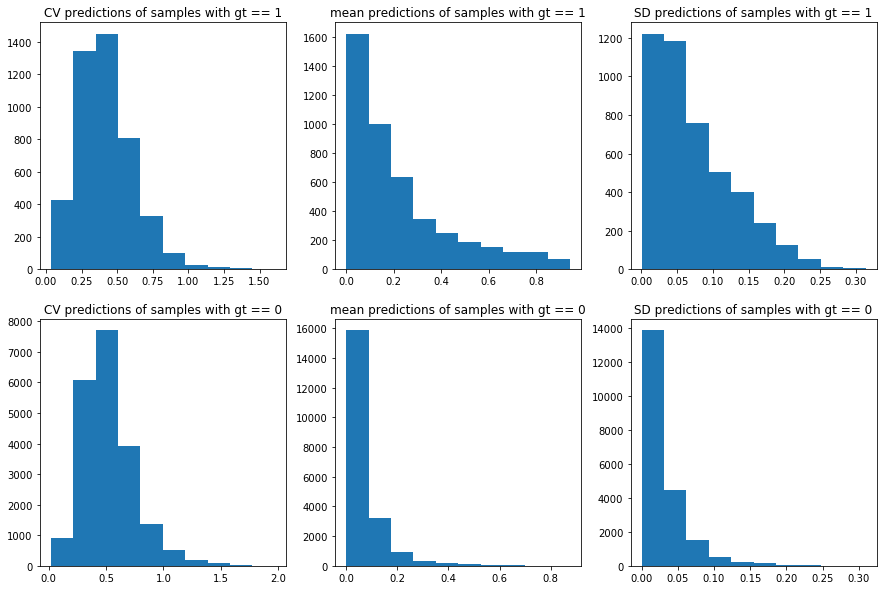

In [9]:
f, ax = plt.subplots(2, 3, figsize=(15, 10))
ax[0, 0].hist(cv_cls_1_list[targets_list==1])
ax[0, 0].set_title('CV predictions of samples with gt == 1')
ax[0, 1].hist(mean_cls_1_list[targets_list==1])
ax[0, 1].set_title('mean predictions of samples with gt == 1')
ax[0, 2].hist(std_cls_1_list[targets_list==1])
ax[0, 2].set_title('SD predictions of samples with gt == 1')
ax[1, 0].hist(cv_cls_1_list[targets_list==0])
ax[1, 0].set_title('CV predictions of samples with gt == 0')
ax[1, 1].hist(mean_cls_1_list[targets_list==0])
ax[1, 1].set_title('mean predictions of samples with gt == 0');
ax[1, 2].hist(std_cls_1_list[targets_list==0])
ax[1, 2].set_title('SD predictions of samples with gt == 0');
#plt.hist(cv_cls_1_list);

We can take only confident predictions, that is CV <= 0.5 for both classes + predicted class  == gt class

In [10]:
old_data.loc[:, 'predicted_target'] = predicted_cls
old_data.loc[:, 'prediction_mean'] = mean_cls_1_list
old_data.loc[:, 'CV'] = cv_cls_1_list
old_data.loc[:, 'std'] = std_cls_1_list
old_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,predicted_target,prediction_mean,CV,std
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767,0,0.232235,0.798983,0.185552
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,0,0.047229,0.189687,0.008959
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767,0,0.157021,0.604588,0.094933
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767,0,0.363409,0.228656,0.083096
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767,0,0.080290,0.626086,0.050268


In [11]:
selection_mask = (cv_cls_1_list <= 0.5) & (predicted_cls == targets_list)

In [12]:
old_data_cleaned = old_data.loc[selection_mask, :]
old_data_cleaned.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,predicted_target,prediction_mean,CV,std
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,0,0.047229,0.189687,0.008959
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767,0,0.363409,0.228656,0.083096
6,ISIC_0000007,-1,female,25.0,posterior torso,NV,benign,0,16,1022,767,0,0.017633,0.464554,0.008191
7,ISIC_0000008,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767,0,0.250929,0.215724,0.054131
8,ISIC_0000009,-1,female,30.0,anterior torso,NV,benign,0,8,1022,767,0,0.043212,0.341889,0.014774


In [13]:
old_data_cleaned.target.value_counts()

0    10728
1      591
Name: target, dtype: int64

In [14]:
old_data.target.value_counts()

0    20763
1     4509
Name: target, dtype: int64

In [15]:
old_data_cleaned.to_csv('../data/external_train_cleaned.csv', index=False)

Check class distrubution in original data

In [16]:
new_data = pd.read_csv('../data/train.csv')
new_data.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [17]:
new_data.target.value_counts()

0    32111
1      581
Name: target, dtype: int64

In [18]:
new_data.diagnosis.value_counts()

unknown                               26697
nevus                                  5191
melanoma                                581
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      35
solar lentigo                             7
atypical melanocytic proliferation        1
cafe-au-lait macule                       1
Name: diagnosis, dtype: int64

In [19]:
pd.crosstab(new_data.target, new_data.diagnosis)

diagnosis,atypical melanocytic proliferation,cafe-au-lait macule,lentigo NOS,lichenoid keratosis,melanoma,nevus,seborrheic keratosis,solar lentigo,unknown
target,,,,,,,,,
0,1,1,44,35,0,5191,135,7,26697
1,0,0,0,0,581,0,0,0,0


In [20]:
old_data_cleaned.diagnosis.value_counts()

NV      6183
BCC     1937
BKL     1561
MEL      591
AK       490
SCC      376
DF       106
VASC      75
Name: diagnosis, dtype: int64

In [21]:
pd.crosstab(old_data_cleaned.target, old_data_cleaned.diagnosis)

diagnosis,AK,BCC,BKL,DF,MEL,NV,SCC,VASC
target,,,,,,,,
0,490,1937,1561,106,0,6183,376,75
1,0,0,0,0,591,0,0,0


In [22]:
pd.crosstab(old_data.target, old_data.diagnosis)

diagnosis,AK,BCC,BKL,DF,MEL,NV,SCC,VASC
target,,,,,,,,
0,867,3320,2616,239,0,12840,628,253
1,0,0,0,0,4509,0,0,0
